In [53]:
import pandas as pd
import os
import pydicom as dicom
import cv2
from matplotlib import pyplot as plt
import numpy as np
import SimpleITK as sitk
import nrrd
from skimage import morphology

In [19]:
image_path = os.path.join("C:/Users/samkr/Downloads/DICOM FILES/annotated/9012435 Annotated")

segmented_path = os.path.join(image_path, "annotated", "9012435-label.nrrd")

In [20]:
slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(image_path)  
image = sitk.ReadImage(slice_filenames)
segmentation = sitk.ReadImage(segmented_path)

In [21]:
image_size = image.GetSize()
image_origin = image.GetOrigin()
image_direction = image.GetDirection()
image_spacing = image.GetSpacing()
print(f"image:\n\tsize = {image_size}\n\torigin = {image_origin}\n\tdirection = {image_direction}\n\tspacing = {image_spacing}")

image:
	size = (512, 256, 15)
	origin = (-214.45782470703125, -86.50602722167969, -39.099998474121094)
	direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
	spacing = (0.78125, 0.78125, 5.0)


In [22]:
segmentation_size = segmentation.GetSize()
segmentation_origin = segmentation.GetOrigin()
segmentation_direction = segmentation.GetDirection()
segmentation_spacing = segmentation.GetSpacing()
print({segmentation_size},{image_origin},{image_direction},{image_spacing})

{(512, 256, 15)} {(-214.45782470703125, -86.50602722167969, -39.099998474121094)} {(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)} {(0.78125, 0.78125, 5.0)}


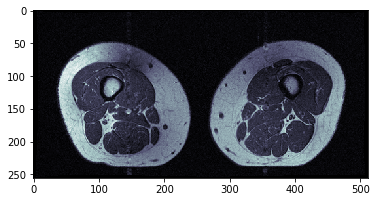

In [23]:
origin_voxel = image[0, 0, 0] # get value of the image origin voxel, i.e. the upper left corner of the first slice
middle_slice = image[:, :, round(image.GetSize()[2] // 2)] # extract the middle slice of the image
cropped_middle_slice = middle_slice[50:-50, 50:-50] # crop 50 pixels from each side

array_from_image = sitk.GetArrayFromImage(image) # numpy array is reversed and metadata on image info lost
image_from_array = sitk.GetImageFromArray(array_from_image)

plt.imshow(sitk.GetArrayFromImage(middle_slice), cmap="bone")

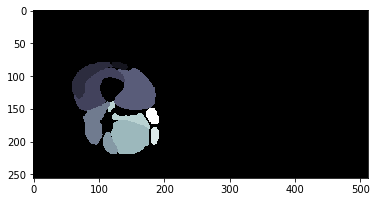

In [25]:
middle_seg_slice = segmentation[:, :, segmentation.GetSize()[2] // 2]
plt.imshow(sitk.GetArrayFromImage(middle_seg_slice), cmap="bone")

In [37]:
def overlay_segmentation(image, segmentation):
    if isinstance(image, sitk.Image):
        image = sitk.GetArrayFromImage(image)
    if isinstance(segmentation, sitk.Image):
        segmentation = sitk.GetArrayFromImage(segmentation)

    overlay = np.ma.masked_where(segmentation == 0, segmentation)
    plt.imshow(image, cmap="bone",vmin=0, vmax=2200)
    plt.imshow(overlay, cmap="rainbow", vmin=1, vmax=10, alpha=0.4)

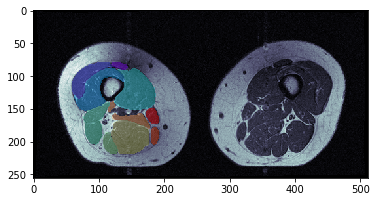

In [38]:
overlay_segmentation(middle_slice, middle_seg_slice)


numpy.ndarray

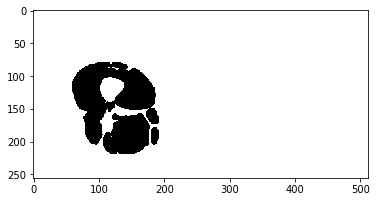

In [45]:
midseg = sitk.GetArrayFromImage(middle_seg_slice)
midimg = sitk.GetArrayFromImage(middle_slice)

midsegmask = (midseg > 0) # create mask by setting 0 values to transparent
midimgc = midsegmask*midimg

plt.imshow(midsegmask, cmap='Greys')

type(midsegmask)

In [46]:
# convert int16 to uint8 
im_in = cv2.normalize(src=midseg, dst=None, alpha=0.0, beta=10.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Threshold.
# Set values above 0 to equal 1.
th, im_th = cv2.threshold(im_in, 0, 1, cv2.THRESH_BINARY_INV);

# Copy the thresholded image.
im_floodfill = im_th.copy()

In [47]:
from skimage import img_as_ubyte

# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

print(im_floodfill.dtype)
print(mask.dtype)

uint8
uint8


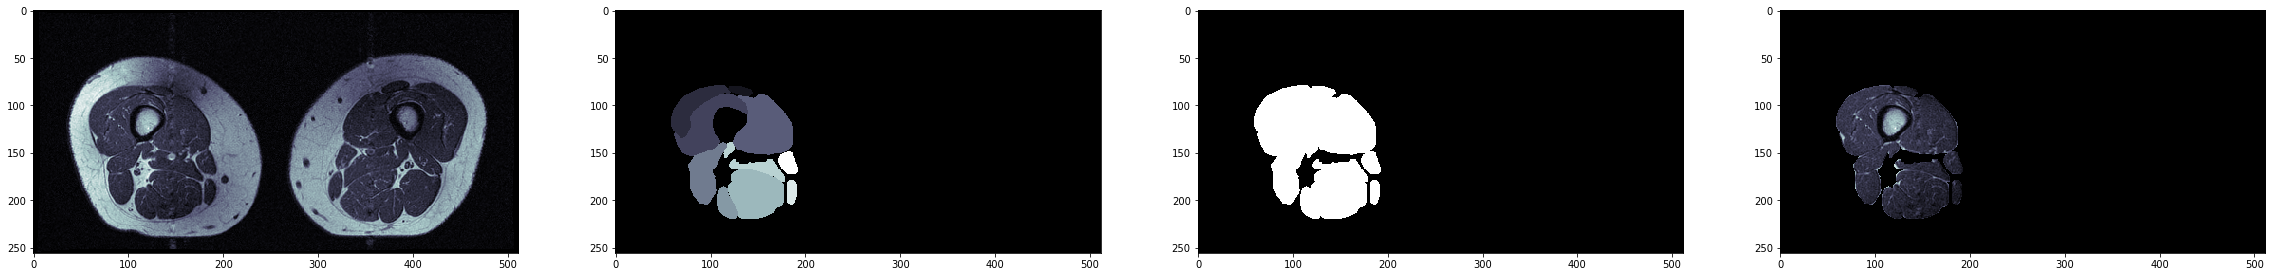

In [48]:
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = im_th | im_floodfill_inv
 
midmask = (im_out > 1)
midmasked = midimg * midmask

fig, ax = plt.subplots(1, 4, figsize=(40, 40))
ax[0].imshow(midimg, cmap="bone")
ax[1].imshow(midseg, cmap="bone")
ax[2].imshow(midmask, cmap="bone")
ax[3].imshow(midmasked, cmap="bone")

#plt.imshow(midseg, cmap="bone")
#plt.imshow(midimg, cmap="bone")

#middle_slice.GetSize()[0]//2
#midimg.GetSize()[0]//2

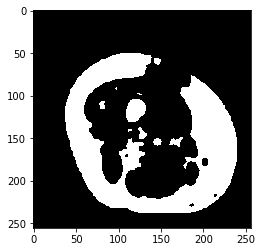

In [49]:
# Otsu histogram based segmentation 
# first convert image type to unsigned 8 uint8:
midimgu8 = cv2.normalize(src=midimg, dst=None, alpha=0.0, beta=10.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# crop image 
y=0
x=0
h=middle_slice.GetSize()[0]//2
w=256

midimgc = midimgu8[y:y+h, x:x+w]

midimgcb = cv2.GaussianBlur(midimgc,(5,5),3)
otsuth,midimgcbt = cv2.threshold(midimgcb,0,2200,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(midimgcbt, cmap="bone")

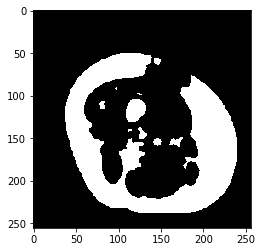

In [50]:
# fill in gaps

# Copy thresholded thigh image
im_floodfill = midimgcbt.copy()

# Create 0's mask 
h, w = im_floodfill.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0) with 255 value 
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
midimg_thmask = midimgcbt | im_floodfill_inv

plt.imshow(midimg_thmask, cmap="bone")

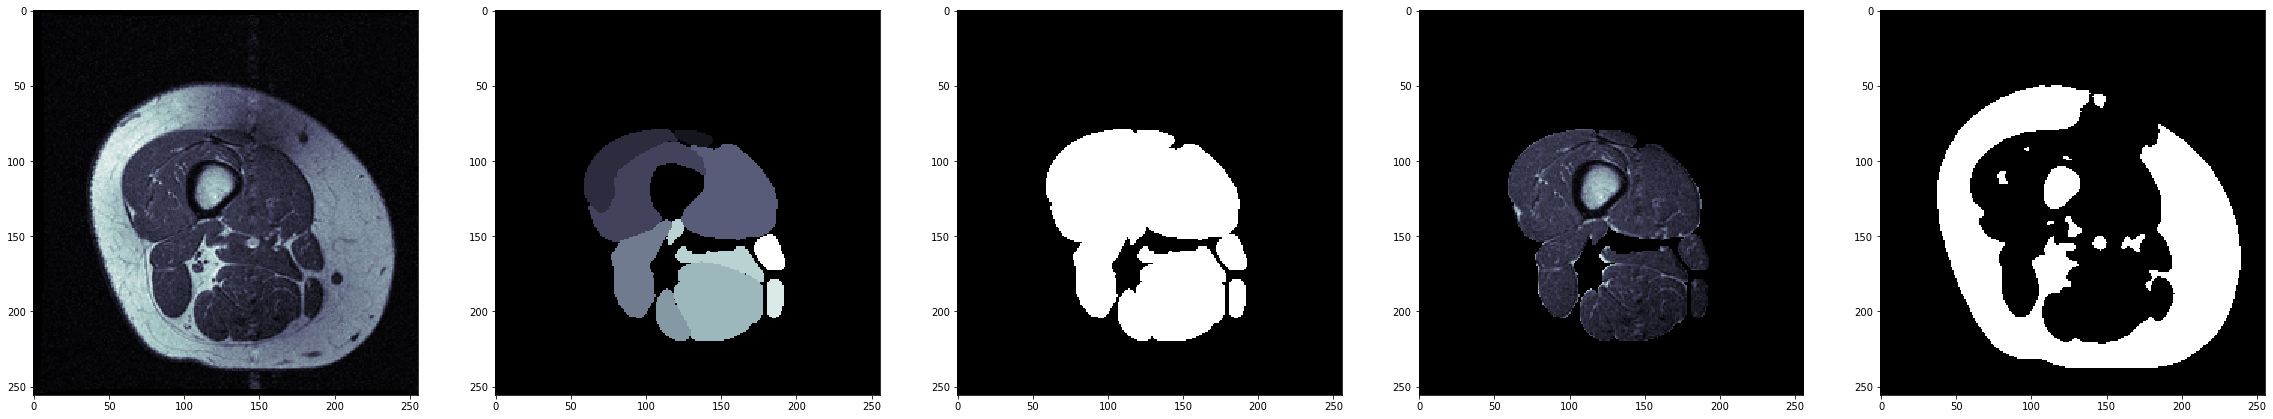

In [57]:
# crop image 
y=0
x=0
h=middle_slice.GetSize()[0]//2
w=256

midimgcr = midimg[y:y+h, x:x+w]
midsegcr = midseg[y:y+h, x:x+w]
midmaskcr = midmask[y:y+h, x:x+w]
midmaskedcr = midmasked[y:y+h, x:x+w]

fig, ax = plt.subplots(1, 5, figsize=(40, 40))
ax[0].imshow(midimgcr, cmap="bone")
ax[1].imshow(midsegcr, cmap="bone")
ax[2].imshow(midmaskcr, cmap="bone")
ax[3].imshow(midmaskedcr, cmap="bone")
ax[4].imshow(midimg_thmask, cmap="bone")

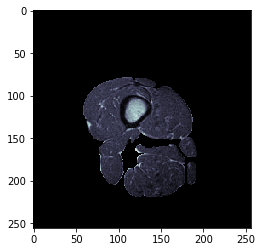

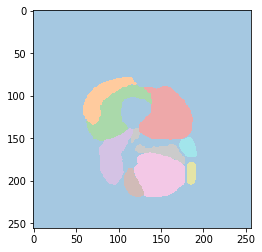

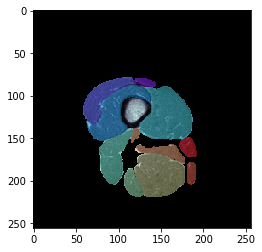

In [68]:
plt.imshow(midmaskedcr, cmap="bone",vmin=0, vmax=2200)
plt.show()
plt.imshow(midsegcr, cmap="tab10", vmin=1, vmax=10, alpha=0.4)
plt.show()
overlay_segmentation( midmaskedcr,midsegcr)


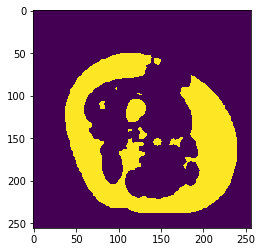

In [54]:
# remove islands of pixels smaller than a certain size 

midimgthi = morphology.remove_small_objects(midimg_thmask,min_size=20, connectivity=1)

plt.imshow(midimgthi)

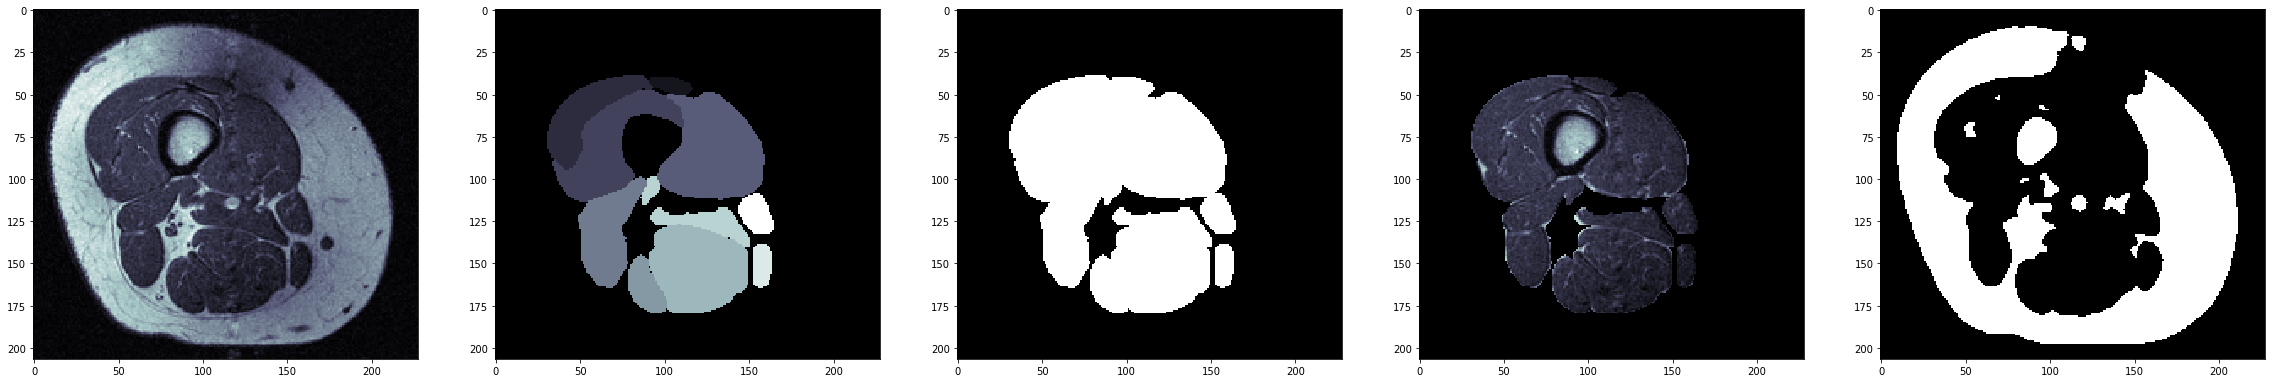

In [55]:
# crop rest of image based on limits of thigh mask 

# Left side 

Lxmin=256
Lywx=256
Lpixv=0

for (y,x), pixel in np.ndenumerate(midimg_thmask):
    if(pixel==255):
        if(x<Lxmin):        
            Lxmin = x
            Lywx = y
            Lpixv = pixel
        else: pass
    else: pass

# Top side 

Tymin=256
Txwy=256
Tpixv=0

for (y,x), pixel in np.ndenumerate(midimg_thmask):
    if(pixel==255):
        if(y<Tymin):        
            Tymin = y
            Txwy = x
            Tpixv = pixel
        else: pass
    else: pass

# Bottom side 

Tymax=0
Txwy=0
Tpixv=0

for (y,x), pixel in np.ndenumerate(midimg_thmask):
    if(pixel==255):
        if(y>Tymax):        
            Tymax = y
            Txwy = x
            Tpixv = pixel
        else: pass
    else: pass    
    
y=Tymin-10
x=0
h=Tymax+10
w=Lxmin-10

midimgthc = midimg_thmask[y:h, w:256]

midimgcr2 = midimg[y:h, w:256]
midsegcr2 = midseg[y:h, w:256]
midmaskcr2 = midmask[y:h, w:256]
midmaskedcr2 = midmasked[y:h, w:256]

fig, ax = plt.subplots(1, 5, figsize=(40, 40))
ax[0].imshow(midimgcr2, cmap="bone")
ax[1].imshow(midsegcr2, cmap="bone")
ax[2].imshow(midmaskcr2, cmap="bone")
ax[3].imshow(midmaskedcr2, cmap="bone")
ax[4].imshow(midimgthc, cmap="bone")